In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

# Vm during movement and rest episodes

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples[samples["SID"] == "W4_C4"].iloc[0]

vm = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/vm/filter.pkl")
vm_data = vm.get_data()

action_potentials = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/action_potentials.csv")
movement = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/movement_episodes.csv")
rest = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/rest_episodes.csv")

## Average Vm during movement

In [3]:
stats = []

for i, episode in movement.iterrows():
    start = episode["EventStart"]
    end = episode["EventEnd"]
    channel = episode["Channel"]
    eid = episode["ID"]

    signal = vm_data[channel, start:end]
    
    stats.append(pd.DataFrame({
        "ID": [ eid ],
        "Mean": [ np.mean(signal) ],
        "SD": [ np.std(signal) ]
    }))

stats = pd.concat(stats)
stats = stats.reset_index(drop = True)
stats

,ID,Mean,SD
0,M0,-54.077014,0.895848
1,M1,-56.066644,0.721247
2,M2,-53.812202,0.828388
3,M3,-55.699698,0.526246
4,M4,-57.574333,0.512756
...,...,...,...
90,M90,-36.311975,3.800587
91,M91,-33.299034,3.318588
92,M92,-37.535402,2.392549
93,M93,-36.452862,1.402069


## Average Vm during movement, excluding AP episodes

In [13]:
continuous_vm_data = []
continuous_vm_data_no_ap = []

stats = []

for i, episode in movement.iterrows():
    start = episode["EventStart"]
    end = episode["EventEnd"]
    channel = episode["Channel"]
    eid = episode["ID"]

    signal_range = np.arange(start, end)

    channel_aps = action_potentials[action_potentials["Channel"] == channel]
    episode_aps = np.logical_and(
        channel_aps["EventStart"] >= start,
        channel_aps["EventStart"] <= end
    )

    n_ap = sum(episode_aps)

    if sum(episode_aps) >= 1:
        # Get APs within the episode and remove their ranges
        episode_aps = channel_aps[episode_aps]
        for j, ap in episode_aps.iterrows():
            ap_start = round(ap["EventStart"])
            ap_end = round(ap["EventEnd"]) + 50

            ap_range = np.arange(ap_start, ap_end)
            signal_range = [i for i in signal_range if i not in ap_range]

    signal = vm_data[channel, start:end]
    signal_no_ap = vm_data[channel, signal_range]

    stats.append(pd.DataFrame({
        "ID": [ eid ],
        "Mean": [ np.mean(signal) ],
        "SD": [ np.std(signal) ],
        "MeanNoAP": [ np.mean(signal_no_ap) ],
        "SDNoAP": [ np.std(signal_no_ap) ],
        "NumberOfAP": [ n_ap ]
    }))

    continuous_vm_data.append(signal)
    continuous_vm_data_no_ap.append(signal_no_ap)

continuous_vm_data = np.concatenate(continuous_vm_data)
continuous_vm_data_no_ap = np.concatenate(continuous_vm_data_no_ap)

stats = pd.concat(stats)
stats = stats.reset_index(drop = True)
stats

,ID,Mean,SD,MeanNoAP,SDNoAP,NumberOfAP
0,M0,-54.077014,0.895848,-54.077014,0.895848,0
1,M1,-56.066644,0.721247,-56.066644,0.721247,0
2,M2,-53.812202,0.828388,-53.812202,0.828388,0
3,M3,-55.699698,0.526246,-55.699698,0.526246,0
4,M4,-57.574333,0.512756,-57.574333,0.512756,0
...,...,...,...,...,...,...
90,M90,-36.311975,3.800587,-36.626023,3.026480,2
91,M91,-33.299034,3.318588,-33.806716,1.720625,2
92,M92,-37.535402,2.392549,-37.535402,2.392549,0
93,M93,-36.452862,1.402069,-36.452862,1.402069,0


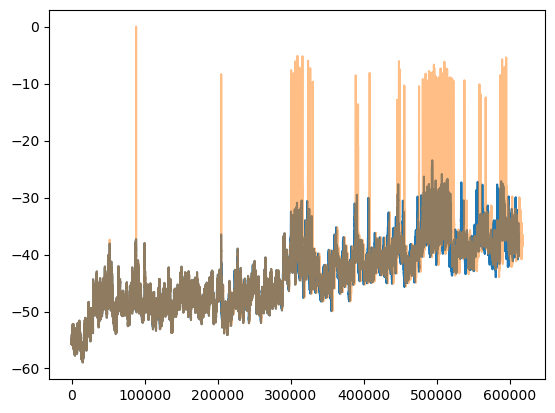

In [5]:
plt.plot(continuous_vm_data_no_ap)
plt.plot(continuous_vm_data, alpha = 0.5)
plt.show()